Text(0, 0.5, '|amplitude|')

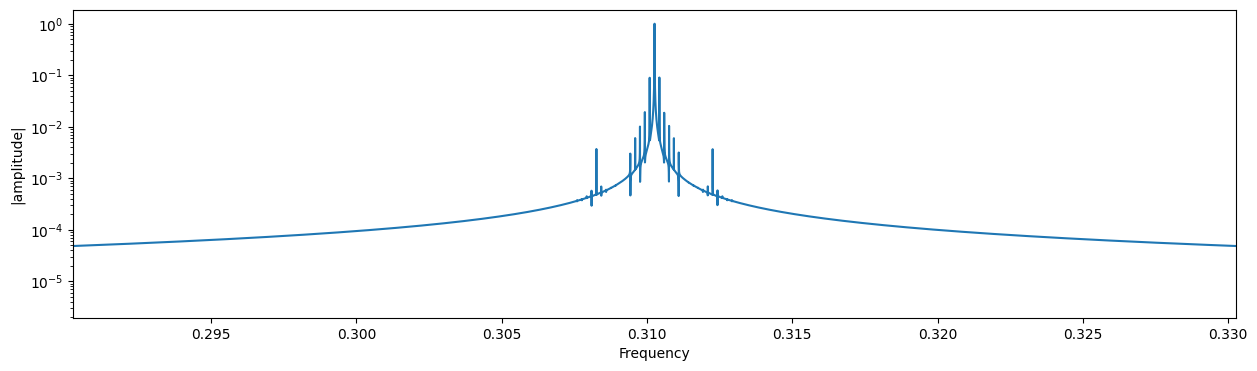

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import scipy.stats as sciStat


import PySUSSIX.f90sussix.f90sussix as f90sussix
from PySUSSIX.f90sussix.sussix import  F90Sussix

import PySUSSIX.crosssussix.crossroutines as crossroutines
import PySUSSIX.crosssussix.crosssussix as crosssussix
import PySUSSIX.crosssussix.crossref as crossref

import PySUSSIX.ducksussix.ducksussix as ducksussix


# Creating dummy x,px
def get_FFT(x):
    x     = np.array(x)
    turns = np.arange(len(x))

    # Cropping signal to closest power of 2
    Nt      = len(x)
    crop_at = 2**int(np.log2(Nt))



    
    spectrum = np.fft.fft(x[:crop_at])
    freq     = np.fft.fftfreq(turns[:crop_at].shape[-1])

    idx      = np.argmax(np.abs(spectrum))
    Qx       = freq[idx]
    return freq[freq>0],np.abs(spectrum)[freq>0]



Q0 = 0.31025793875089835
Qs = 0.002
dQ = Qs/12
Jx = (0.5*(10**2))

n_bands_Qs = 1
n_bands_dQ = 5
N   = np.arange(int(1e6))
j   = np.arange(-n_bands_Qs,n_bands_Qs+1)
i   = np.arange(-n_bands_dQ,n_bands_dQ+1)



Ai  = sciStat.cauchy.pdf(i/np.max(i),0,0.05)
Aj  = sciStat.cauchy.pdf(j/np.max(j),0,0.05)
Ai  = Ai/np.max(Ai)
Aj  = Aj/np.max(Aj)
np.random.seed(0)
phii = np.zeros(len(i))#np.random.uniform(-np.pi/2,np.pi/2,len(i))
phij = np.zeros(len(j))#np.random.uniform(-np.pi/2,np.pi/2,len(j)) 
# x = sum([sum([ _Ai*_Aj * np.sin(2*np.pi*(Q0+ _j*Qs + _i*dQ)*N) for _i,_Ai in zip(i,Ai) ]) for _j,_Aj in zip(j,Aj) ])
hx_full = sum([sum([ np.sqrt(2*Jx)*_Ai*_Aj * np.exp(1j*2*np.pi*(Q0+ _j*Qs + _i*dQ)*N + _phii + _phij) for _i,_Ai,_phii in zip(i,Ai,phii) ]) for _j,_Aj,_phij in zip(j,Aj,phij) ])
x  = hx_full.real
px = hx_full.imag

expected = pd.DataFrame({'amplitude':np.array([[ (np.sqrt(2*Jx)*_Ai*_Aj) for _i,_Ai,_phii in zip(i,Ai,phii) ] for _j,_Aj,_phij in zip(j,Aj,phij) ]).flatten(),
                         'frequency':np.array([[Q0+ _j*Qs + _i*dQ for _i,_Ai,_phii in zip(i,Ai,phii) ] for _j,_Aj,_phij in zip(j,Aj,phij) ]).flatten()})
expected.sort_values(by='amplitude',ascending=False,inplace=True)
expected.reset_index(drop=True,inplace=True)
# plt.figure()
# plt.plot(x,px,'o',alpha=0.002)
# plt.axis('square')
# plt.xlabel('x')
# plt.ylabel('px')


plt.figure(figsize=(15,4))
freq,spectrum = get_FFT(hx_full)
plt.plot(freq,spectrum/np.max(spectrum),'-')
plt.yscale('log')
plt.xlim(Q0-10*Qs,Q0+10*Qs)
plt.xlabel('Frequency')
plt.ylabel('|amplitude|')

# plt.figure(figsize=(15,4))
# freq,spectrum = get_FFT(x)
# plt.plot(freq,spectrum/np.max(spectrum),'-')
# plt.yscale('log')
# # plt.xlim(Q0-10*dQ,Q0+10*dQ)
# plt.xlim(Q0-1*Qs,Q0+1*Qs)
# plt.xlabel('Frequency')
# plt.ylabel('|amplitude|')

# display(expected)


---
# Convergence study
---

In [ ]:
N = int(1e4 )
results = ducksussix.datspe(    x       = x[:N], 
                                px      = px[:N],
                                y       = None,
                                py      = None,
                                zeta    = None,
                                pzeta   = None,
                                number_of_harmonics = 2*len(expected),Hann_order = 1)

In [ ]:
results['x'].loc[25:45]

In [2]:

x,px = hx_full.real,hx_full.imag
N_vec = np.logspace(3,5,50).astype(int)

freq_df = []
amp_df = []
exc_df = []
for N in N_vec:
    results = ducksussix.get_harmonics( x       = x[:N], 
                                        px      = px[:N],
                                        y       = None,
                                        py      = None,
                                        zeta    = None,
                                        pzeta   = None,
                                        number_of_harmonics = len(expected),Hann_order = 1,
                                        optimization='fortran')

    # Finding matching line, higher weight on the frequency.
    tol_amp  = 1e0
    # tol_freq = dQ
    found = results['x'].copy()
    found.amplitude = found.amplitude.abs()
    found.insert(0,'match',np.nan)
    for line in found.index:
        distance = 0.2*(expected['amplitude']-found.loc[line,'amplitude'])**2 + 0.8*(expected['frequency']-found.loc[line,'frequency'])**2
        if np.sqrt(distance.min())/found.loc[line,'amplitude'] <1e-1 :#+ 0.8*(tol_freq)**2:
            found.loc[line,'match'] = int(distance.idxmin())

    # Creating frequency and amplitude table
    df_f = pd.DataFrame({f'freq:{i}':[np.nan] for i in expected.index},index=[N])
    df_a = pd.DataFrame({f'Err_amp:{i}':[np.nan] for i in expected.index},index=[N])
    exc_count = 0
    for idx,row in found.iterrows():
        if not pd.isna(row['match']):
            df_f.loc[N,f'freq:{row["match"]:.0f}'] = row['frequency']
            df_a.loc[N,f'Err_amp:{row["match"]:.0f}']  = np.abs(row['amplitude']-expected.loc[row["match"]].amplitude)/expected.loc[row["match"]].amplitude
        else:
            exc_count += 1
    df_exc =  pd.DataFrame({f'excluded':[exc_count] for i in expected.index},index=[N])


    # saving results
    freq_df.append(df_f)
    amp_df.append(df_a)
    exc_df.append(df_exc)


df_freq = pd.concat(freq_df)
df_amp  = pd.concat(amp_df)
df_exc  = pd.concat(exc_df)

---
# Plotting
---

(2e-06, 10.0)

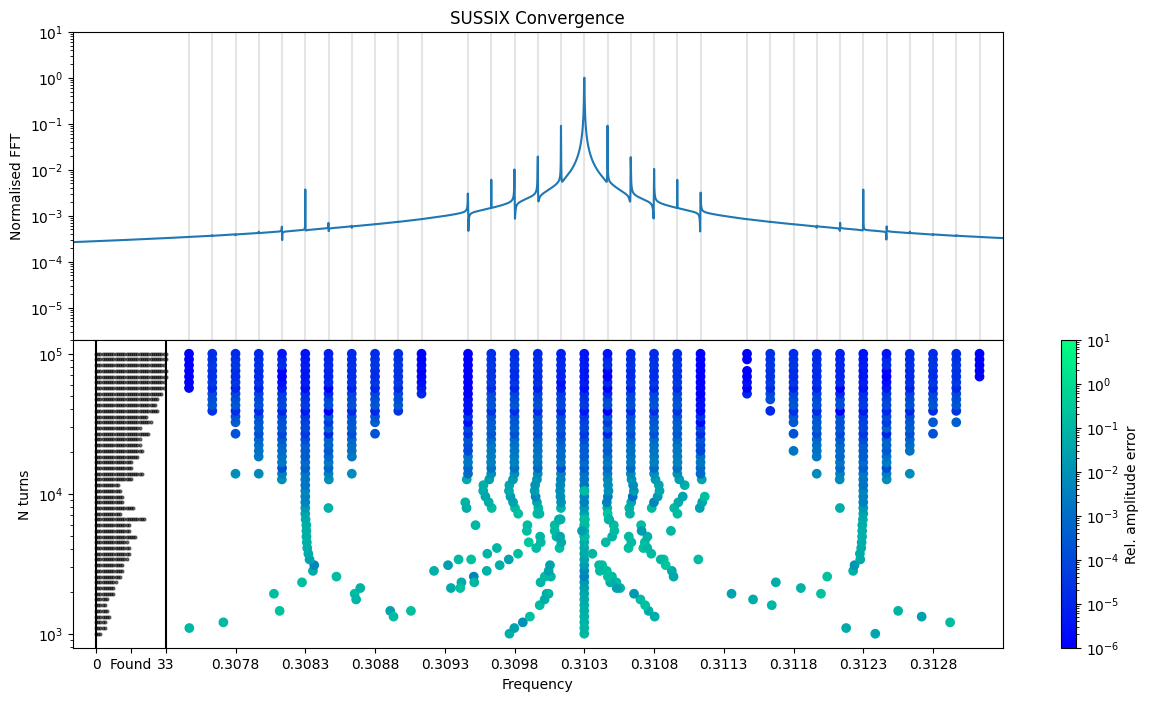

In [3]:
import matplotlib.colors as colors
vmin = 1e-6
vmax = 1e1
fig, axs = plt.subplots(2, 1,figsize=(15,8))
plt.subplots_adjust(hspace=0)

plt.sca(axs[1])
axs[0].set_title('SUSSIX Convergence')
for col in df_freq.columns:
    idx = col.split(':')[-1]
    plt.scatter(df_freq[col],df_freq.index,c=df_amp[f'Err_amp:{idx}'],norm=colors.LogNorm(vmin=vmin, vmax=vmax),
                                                                cmap='winter')
plt.colorbar(label='Rel. amplitude error')

# Adding excluded points

x_exc_template = np.linspace(expected.frequency.min()-4*dQ,expected.frequency.min()-dQ,len(expected))
x_exec = np.array([list(x_exc_template[:len(expected)-row['excluded']]) + (row['excluded'])*[np.nan] for idx,row in df_exc.iterrows()])
y_exec = np.array([len(expected)*[idx] for idx,row in df_exc.iterrows()])

plt.plot(x_exec.flatten(),y_exec.flatten(),'o',ms=2,color='k',alpha=0.5)
plt.axvline(x_exc_template.max(),color='k')
plt.axvline(x_exc_template.min(),color='k')

plt.yscale('log')
plt.xlim(expected.frequency.min()-5*dQ,expected.frequency.max()+dQ)
plt.xlabel('Frequency')
plt.ylabel('N turns')
xticks = [x_exc_template.min(),x_exc_template.mean(),x_exc_template.max()] + list(np.linspace(Q0-15*dQ,Q0+15*dQ,11)) 
plt.gca().set_xticks(xticks,['0','Found',str(len(expected))] + [f'{_x:.4f}' for _x in xticks[3:]]);


plt.sca(axs[0])
freq,spectrum = get_FFT(hx_full)
plt.plot(freq,spectrum/np.max(spectrum),'-')
plt.scatter(np.nan,np.nan)
cbar = plt.colorbar()
cbar.ax.set_visible(False)
plt.xticks([])

plt.yscale('log')
plt.xlim(Q0-10*Qs,Q0+10*Qs)
plt.ylabel('Normalised FFT')
plt.xlim(expected.frequency.min()-5*dQ,expected.frequency.max()+dQ)
for line in expected.frequency:
    plt.axvline(line,color='k',alpha=0.1,zorder=-10)
plt.ylim(2e-6,1e1)

In [5]:
_N = 1e5
x  = hx_full.real[:int(_N)]
px = hx_full.imag[:int(_N)]
# Windowing of the signal
N   = np.arange(len(x))
z   = np.array(x) + 1j*np.array(px)
z_w = z * ducksussix.Hann(N, Nt=len(z),p=1)

# Estimation of the tune with FFT
tune_est,resolution = ducksussix.FFT_tune_estimate(z_w)

# Preparing the estimate for the Newton refinement method
if tune_est >= 0.5:
    tune_est = -(1.0 - tune_est)
tune_est = tune_est - resolution

# Refinement of the tune calulation

    # tune,amplitude = crossroutines.zfunr(z_w,tune_est)
    # amplitude /= len(z_w)
# import PySUSSIX.ducksussix.f90newton as f90newton
tune,amplitude = ducksussix.f90newton_method(z_w,tune_est,resolution)
print(tune,amplitude)
tune,amplitude = ducksussix.newton_method(z_w,N,tune_est,resolution)
# tune,amplitude = crossroutines.zfunr(z_w,tune_est)
# amplitude /= len(z_w)
print(tune,amplitude)

0.31025793875089835 (10.000033962066766+2.3433507527281747e-12j)
0.3102579387508983 (10.000033962059327+1.1102391298924986e-10j)


In [6]:
_N = 1e3
x  = hx_full.real[:int(_N)]
px = hx_full.imag[:int(_N)]
# Windowing of the signal
N   = np.arange(len(x))
z   = np.array(x) + 1j*np.array(px)
z_w = z * ducksussix.Hann(N, Nt=len(z),p=1)

# Estimation of the tune with FFT
tune_est,resolution = ducksussix.FFT_tune_estimate(z_w)

# Preparing the estimate for the Newton refinement method
if tune_est >= 0.5:
    tune_est = -(1.0 - tune_est)
tune_est = tune_est - resolution

# Refinement of the tune calulation

    # tune,amplitude = crossroutines.zfunr(z_w,tune_est)
    # amplitude /= len(z_w)
# import PySUSSIX.ducksussix.f90newton as f90newton
tune,amplitude = ducksussix.f90newton_method(z_w,tune_est,resolution)
print(tune,amplitude)
tune,amplitude = crossroutines.zfunr(z_w,tune_est)
amplitude /= len(z_w)
print(tune,amplitude)

0.3102579387508983 (11.089691087333767+1.4410594191147628e-12j)
0.3102579387508983 (11.089691087333767+1.4410594191147628e-12j)


In [13]:
_N = int(1e3)
x,px = np.zeros(int(1e5)),np.zeros(int(1e5))
x[:_N]  = hx_full.real[:int(_N)]
px[:_N] = hx_full.imag[:int(_N)]
x  = hx_full.real[:int(_N)]
px = hx_full.imag[:int(_N)]
# Windowing of the signal
N   = np.arange(len(x))
z   = np.array(x) + 1j*np.array(px)
z_w = z * ducksussix.Hann(N, Nt=len(z),p=1)

# Estimation of the tune with FFT
tune_est,resolution = ducksussix.FFT_tune_estimate(z_w)

# Preparing the estimate for the Newton refinement method
if tune_est >= 0.5:
    tune_est = -(1.0 - tune_est)
tune_est = tune_est - resolution

# Refinement of the tune calulation

    # tune,amplitude = crossroutines.zfunr(z_w,tune_est)
    # amplitude /= len(z_w)
# import PySUSSIX.ducksussix.f90newton as f90newton
tune,amplitude = ducksussix.f90newton_method(z_w,tune_est,resolution)
print(tune,amplitude)
tune,amplitude = crossroutines.zfunr(z_w,tune_est)
amplitude /= len(z_w)
print(tune,amplitude)

0.3102579387508983 (11.089691087333767+1.4410594191147628e-12j)
0.3102579387508983 (11.089691087333767+1.4410594191147628e-12j)


In [10]:
x

array([11.8083927 , -4.36474428, -8.58167819, ...,  0.        ,
        0.        ,  0.        ])

---
# NAFFLib comparison
---

In [ ]:

import NAFFlib
import gc
import importlib


x,px = hx_full.real,hx_full.imag
N_vec = np.logspace(3,5,100).astype(int)

freq_df = []
amp_df = []
exc_df = []
naff_Q = 0
naff_A = 0
for N in N_vec:

    importlib.reload(NAFFlib)
    del(naff_Q)
    del(naff_A)
    gc.collect()

    def NAFFlib_tune(x,nfreqs = 1,Hann_order=1):
            x        = np.array(x)
            Q,A,An  = NAFFlib.get_tunes(x, nfreqs, Hann_order)

            if nfreqs ==1:
                return Q[0]
            else:
                
                return Q,np.abs(A)
            
    naff_Q,naff_A = NAFFlib_tune(hx_full[:N],nfreqs=len(expected),Hann_order=1)
    naff_results = pd.DataFrame({'amplitude':naff_A,'frequency':naff_Q})

    # Finding matching line, higher weight on the frequency.
    tol_amp  = 1e0
    # tol_freq = dQ
    found = naff_results.copy()
    found.amplitude = found.amplitude.abs()
    found.insert(0,'match',np.nan)
    for line in found.index:
        distance = 0.2*(expected['amplitude']-found.loc[line,'amplitude'])**2 + 0.8*(expected['frequency']-found.loc[line,'frequency'])**2
        if np.sqrt(distance.min())/found.loc[line,'amplitude'] <1e-1 :#+ 0.8*(tol_freq)**2:
            found.loc[line,'match'] = int(distance.idxmin())

    # Creating frequency and amplitude table
    df_f = pd.DataFrame({f'freq:{i}':[np.nan] for i in expected.index},index=[N])
    df_a = pd.DataFrame({f'Err_amp:{i}':[np.nan] for i in expected.index},index=[N])
    exc_count = 0
    for idx,row in found.iterrows():
        if not pd.isna(row['match']):
            df_f.loc[N,f'freq:{row["match"]:.0f}'] = row['frequency']
            df_a.loc[N,f'Err_amp:{row["match"]:.0f}']  = np.abs(row['amplitude']-expected.loc[row["match"]].amplitude)/expected.loc[row["match"]].amplitude
        else:
            exc_count += 1
    df_exc =  pd.DataFrame({f'excluded':[exc_count] for i in expected.index},index=[N])


    # saving results
    freq_df.append(df_f)
    amp_df.append(df_a)
    exc_df.append(df_exc)


df_freq = pd.concat(freq_df)
df_amp  = pd.concat(amp_df)
df_exc  = pd.concat(exc_df)

In [ ]:
import matplotlib.colors as colors
vmin = 1e-6
vmax = 1e1
fig, axs = plt.subplots(2, 1,figsize=(15,8))
plt.subplots_adjust(hspace=0)

plt.sca(axs[1])
axs[0].set_title('NAFFlib Convergence')
for col in df_freq.columns:
    idx = col.split(':')[-1]
    plt.scatter(df_freq[col],df_freq.index,c=df_amp[f'Err_amp:{idx}'],norm=colors.LogNorm(vmin=vmin, vmax=vmax),
                                                                cmap='winter')
plt.colorbar(label='Rel. amplitude error')

# Adding excluded points

x_exc_template = np.linspace(expected.frequency.min()-4*dQ,expected.frequency.min()-dQ,len(expected))
x_exec = np.array([list(x_exc_template[:len(expected)-row['excluded']]) + (row['excluded'])*[np.nan] for idx,row in df_exc.iterrows()])
y_exec = np.array([len(expected)*[idx] for idx,row in df_exc.iterrows()])

plt.plot(x_exec.flatten(),y_exec.flatten(),'o',ms=2,color='k',alpha=0.5)
plt.axvline(x_exc_template.max(),color='k')
plt.axvline(x_exc_template.min(),color='k')

plt.yscale('log')
plt.xlim(expected.frequency.min()-5*dQ,expected.frequency.max()+dQ)
plt.xlabel('Frequency')
plt.ylabel('N turns')
xticks = [x_exc_template.min(),x_exc_template.mean(),x_exc_template.max()] + list(np.linspace(Q0-15*dQ,Q0+15*dQ,11)) 
plt.gca().set_xticks(xticks,['0','Found',str(len(expected))] + [f'{_x:.4f}' for _x in xticks[3:]]);


plt.sca(axs[0])
freq,spectrum = get_FFT(hx_full)
plt.plot(freq,spectrum/np.max(spectrum),'-')
plt.scatter(np.nan,np.nan)
cbar = plt.colorbar()
cbar.ax.set_visible(False)
plt.xticks([])

plt.yscale('log')
plt.xlim(Q0-10*Qs,Q0+10*Qs)
plt.ylabel('Normalised FFT')
plt.xlim(expected.frequency.min()-5*dQ,expected.frequency.max()+dQ)
for line in expected.frequency:
    plt.axvline(line,color='k',alpha=0.1,zorder=-10)
plt.ylim(2e-6,1e1)

In [ ]:
sorted(expected.frequency.values)[::5]

In [ ]:
df_exc

In [ ]:
amp_error

In [ ]:
amp_goal

In [ ]:
results['x']

In [ ]:
plt.figure(figsize=(15,4))
for col in df.columns:
    plt.plot(df[col],df.index,'.',color='C0')

plt.yscale('log')
plt.xlim(expected.frequency.min()-dQ,expected.frequency.max()+dQ)

In [ ]:
import NAFFlib

# naff_Q,naff_A = NAFFlib_tune(hx_full,nfreqs=len(expected),Hann_order=2)
# naff_results = pd.DataFrame({'amplitude':naff_A,'frequency':naff_Q})

import gc
import importlib

importlib.reload(NAFFlib)
del(naff_Q)
del(naff_A)
gc.collect()

def NAFFlib_tune(x,nfreqs = 1,Hann_order=1):
        x        = np.array(x)
        Q,A,An  = NAFFlib.get_tunes(x, nfreqs, Hann_order)

        if nfreqs ==1:
            return Q[0]
        else:
            
            return Q,np.abs(A)

N = int(1e5)

naff_Q,naff_A = NAFFlib_tune(hx_full[:N],nfreqs=len(expected),Hann_order=1)
naff_results = pd.DataFrame({'amplitude':naff_A,'frequency':naff_Q})


In [ ]:
naff_results

In [ ]:
pd.DataFrame({f'freq:{i[0]}':[i[1]] for i in results['x'].frequency.items()},index=[1e5])

In [ ]:

N = int(1e3)
results = ducksussix.datspe(x       = x[:N], 
                                px      = px[:N],
                                y       = None,
                                py      = None,
                                zeta    = None,
                                pzeta   = None,
                                number_of_harmonics = len(expected),Hann_order = 1)

plt.figure(figsize=(15,4))
plt.plot()
plt.plot(expected['frequency'],expected['amplitude'],'o',label='expected')
plt.plot(results['x']['frequency'],np.abs(results['x']['amplitude']),'.',label='ducksussix')
# plt.plot(datspe_x['txa'],np.abs(datspe_x['zxpes']),'x',label='crosssussix')
# plt.plot(naff_results['frequency'],np.abs(naff_results['amplitude']),'+',label='NAFF')
plt.yscale('log')
plt.legend(title=f'N points: {len(hx_full):.0e}')
plt.xlabel('frequency')
plt.ylabel('|amplitude|')
plt.xlim(Q0-6*Qs,Q0+6*Qs)

plt.figure(figsize=(15,4))
plt.plot()
plt.plot(expected['frequency'],expected['amplitude'],'o',label='expected')
plt.plot(results['x']['frequency'],np.abs(results['x']['amplitude']),'.',label='ducksussix')
# plt.plot(datspe_x['txa'],np.abs(datspe_x['zxpes']),'x',label='crosssussix')
# plt.plot(naff_results['frequency'],np.abs(naff_results['amplitude']),'+',label='NAFF')
plt.yscale('log')
plt.legend(title=f'N points: {len(hx_full):.0e}')
plt.xlabel('frequency')
plt.ylabel('|amplitude|')
plt.xlim(Q0-10*dQ,Q0+10*dQ)

In [ ]:
plt.figure(figsize=(15,4))
plt.plot()
plt.plot(expected['frequency'],expected['amplitude'],'o',label='expected')
plt.plot(results['x']['frequency'],np.abs(results['x']['amplitude']),'.',label='ducksussix')
# plt.plot(datspe_x['txa'],np.abs(datspe_x['zxpes']),'x',label='crosssussix')
plt.plot(naff_results['frequency'],np.abs(naff_results['amplitude']),'+',label='NAFF')
plt.yscale('log')
plt.legend(title=f'N points: {len(hx_full):.0e}')
plt.xlabel('frequency')
plt.ylabel('|amplitude|')
plt.xlim(Q0-6*Qs,Q0+6*Qs)

plt.figure(figsize=(15,4))
plt.plot()
plt.plot(expected['frequency'],expected['amplitude'],'o',label='expected')
plt.plot(results['x']['frequency'],np.abs(results['x']['amplitude']),'.',label='ducksussix')
# plt.plot(datspe_x['txa'],np.abs(datspe_x['zxpes']),'x',label='crosssussix')
plt.plot(naff_results['frequency'],np.abs(naff_results['amplitude']),'+',label='NAFF')
plt.yscale('log')
plt.legend(title=f'N points: {len(hx_full):.0e}')
plt.xlabel('frequency')
plt.ylabel('|amplitude|')
plt.xlim(Q0-10*dQ,Q0+10*dQ)

---
# Root finding
---

In [ ]:
test = 0
test.real

In [ ]:




def tunenewt(x,px,hanning_order = 1):
    """COMPUTES THE TUNE USING A DISCRETE VERSION OF LASKAR METHOD.
        IT INCLUDES A NEWTON METHOD FOR THE SEARCH OF THE FREQUENCY."""

    # Estimation of Tune with FFT
    maxn = len(x)
    mft = int(np.log2(maxn))
    npoint = 2**mft
    maxn2 = maxn // 2
    step = 2 * np.pi / maxn

    mf_values = np.arange(1, maxn +1)


    z = (np.array(x) + 1j *np.array(px)) * (1.0 + np.cos(step * (mf_values - maxn2)))

    # N    = np.arange(len(x))
    # z2   = np.array(x) + 1j*np.array(px)
    # z2_w = z# * ducksussix.Hann(N, Nt=len(z),p=1)
    # print(z)
    # print(z2_w)

    # Search for maximum in Fourier spectrum
    # zsing = crossroutines.cfft(z)
    zsing = np.fft.fft(z[:npoint])
    ftmax = np.max(np.abs(zsing[:npoint]))
    nftmax = np.argmax(np.abs(zsing[:npoint]))
    
    tunefou = float(nftmax ) / float(npoint)
    
    if tunefou >= 0.5:
        tunefou = -(1.0 - tunefou)
    deltat = 1.0 / float(npoint)

    
    tune1 = tunefou - deltat
    
    
    # Call zfun
    # print('est:',tune1)
    print('tune1',tune1)
    tune,zw = crossroutines.zfunr(z,tune1)


    # Windowing of the signal
    N   = np.arange(len(x))
    z   = np.array(x) + 1j*np.array(px)
    z_w = z * ducksussix.Hann(N, Nt=len(z),p=1)
    
    # Estimation of the tune with FFT
    tune_est,resolution = ducksussix.FFT_tune_estimate(z_w)

    # Preparing the estimate for the Newton refinement method
    if tune_est >= 0.5:
        tune_est = -(1.0 - tune_est)
    tune_est = tune_est - resolution

    # Refinement of the tune calulation
    print('tune_est',tune_est)
    tune,amplitude = crossroutines.zfunr(z_w,tune_est)
    # print(tune,zw)

    # def zfun(tune, z, maxn):
    #     # Implementation of the function z(tune)
    #     # Modify this based on your actual function
    #     ztune = np.exp(-1j * 2 * np.pi * tune.real)
    #     return np.polyval(z[::-1], ztune)

    # def zfund(tune, z, maxn):
    #     # Implementation of the function z(tune)
    #     # Modify this based on your actual function

    #     zd = 1j * np.arange(1, maxn + 1) * z
    #     ztune = np.exp(-1j * 2 * np.pi * tune.real)
    #     return np.polyval(zd[::-1], ztune)



    # # Additional arguments to pass to the function and its derivative
    # args = (z, len(z))

    # # Tolerance for convergence
    # tolerance = 1e-10

    # # Use Newton's method with specified tolerance
    # # from scipy.optimize import newton
    # # result_tune = newton(zfun, tune1,fprime=zfund, args=args)
    # # print(tune1)

    # # print(result_tune)

    return tune,zw


number_of_harmonics = 10
# initialisation
x,px = hx_full.real,hx_full.imag
z  = x + 1j*px
N  = np.arange(len(x))


frequencies = []
amplitudes  = [] 
for _ in range(number_of_harmonics):

    # Computing frequency and amplitude
    print('**')
    print(_)
    # freq,zw = tunenewt(x,px)
    # print(freq,zw)
    freq,zw  = ducksussix.fundamental_frequency(x,px,Hann_order=1)
    print(freq,zw)
    freq2,zw2 = crossroutines.tunenewt(x,px)
    print(freq2,zw2)
    print(40*'-')
    # freq,zw = crossroutines.tunenewt(x,px)
    zpesi   = zw #/ max(N+1)

    # Saving results
    frequencies.append(freq)
    amplitudes.append(zpesi)

    # Substraction procedure
    zgs  = zpesi * np.exp(2 * np.pi * 1j * freq * N)
    z   -= zgs
    x,px = np.real(z), np.imag(z)

In [ ]:
expected.loc[9].frequency

In [ ]:
np.arange(10)

In [ ]:
x,px = hx_full.real,hx_full.imag
z  = x + 1j*px

# Estimation of Tune with FFT
maxn = len(x)
mft = int(np.log2(maxn))
npoint = 2**mft
maxn2 = maxn // 2
step = 2 * np.pi / maxn

mf_values = np.arange(1, maxn +1)
N   = np.arange(len(x))

window_schmidt = (1.0 + np.cos(step * (mf_values - maxn2)))
window_hann    = ducksussix.Hann(N, Nt=len(z),p=1)

plt.figure()
plt.plot(window_schmidt,'-',label='schmidt')
plt.plot(window_hann,'-',label='hann')
plt.legend()
# # z = (np.array(x) + 1j *np.array(px)) * (1.0 + np.cos(step * (mf_values - maxn2)))

# N    = np.arange(len(x))
# z2   = np.array(x) + 1j*np.array(px)
# z2_w = z# * ducksussix.Hann(N, Nt=len(z),p=1)

In [ ]:
mf_values

In [ ]:
N

In [ ]:
window_hann

In [ ]:
window_schmidt

In [ ]:
def zfun(tune, z, maxn):
    # Implementation of the function z(tune)
    # Modify this based on your actual function
    ztune = np.exp(-1j * 2 * np.pi * tune)
    return np.abs(np.polyval(z[::-1], ztune))

x,px = hx_full.real,hx_full.imag
z  = x + 1j*px
# Estimation of Tune with FFT
maxn = len(x)
mft = int(np.log2(maxn))
npoint = 2**mft
maxn2 = maxn // 2
step = 2 * np.pi / maxn

mf_values = np.arange(1, maxn +1)

freq,zw = tunenewt(x,px)


# Search for maximum in Fourier spectrum
# zsing = crossroutines.cfft(z)
zsing = np.fft.fft(z[:npoint])
ftmax = np.max(np.abs(zsing[:npoint]))
nftmax = np.argmax(np.abs(zsing[:npoint]))

tunefou = float(nftmax ) / float(npoint)

if tunefou >= 0.5:
    tunefou = -(1.0 - tunefou)
deltat = 1.0 / float(npoint)


tune1 = tunefou - deltat

z = (np.array(x) + 1j *np.array(px)) * (1.0 + np.cos(step * (mf_values - maxn2)))


f_test = np.linspace(freq-0.5e-4,freq+0.5e-4,1000)

value = [zfun(_f,z,len(z)) for _f in f_test]

plt.figure()
plt.plot(f_test,value)
plt.axvline(freq)
plt.axvline(tune1)

In [ ]:
tune1

In [ ]:
plt.figure()
plt.plot(f_test,value)
plt.axvline(freq)
plt.axvline(tune1)
plt.xlim(freq-0.5e-4,freq+0.5e-4)

In [ ]:
tune1

In [ ]:

scaling = 1e6
from scipy.optimize import minimize
def zfun(tune, z, maxn):
    # Implementation of the function z(tune)
    # Modify this based on your actual function
    ztune = np.exp(-1j * 2 * np.pi * tune/scaling)
    return np.log(np.abs(np.polyval(z[::-1], ztune)))

def zfund(tune, z, maxn):
    # Implementation of the function z(tune)
    # Modify this based on your actual function

    zd = 1j * np.arange(1, maxn + 1) * z
    ztune = np.exp(-1j * 2 * np.pi * tune/scaling)
    return np.log(np.abs(np.polyval(zd[::-1], ztune)))


args = (z, len(z))
results = minimize(zfun, x0=[tune1*scaling],jac=zfund, args=args)#,  bounds=[((tune1-1e-4)*scaling,(tune1+1e-4)*scaling)]))

In [ ]:
print(results.x[0]/scaling)
print(freq)

In [ ]:



x,px = hx_full.real,hx_full.imag
print(ducksussix.tunenewt(x,px,hanning_order = 1))
print(crosssussix.tunenewt(x,px,hanning_order = 1))

In [ ]:


for part in [dummy,particle0,particle1]:
    x,px = part.x_sig,part.px_sig
    print(40*'-')
    print(ducksussix.tunenewt(x,px))
    print(crossroutines.tunenewt(x,px))

In [ ]:
part  = dummy
datspe_x,datspe_y,datspe_s = crosssussix.datspe(part.x_sig,part.px_sig,
                            part.y_sig,part.py_sig,
                            part.zeta_sig,part.pzeta_sig,
                            number_of_harmonics = 5,method = 'hanning',return_values = True)
ordres_x,ordres_y,ordres_s  = crosssussix.ordres(len(part.x_sig),tune_estimate = [0.31,0.32,0.0018],number_of_harmonics = 5,return_values = True)
part  = dummy
results = ducksussix.datspe(x       = part.x_sig, 
                            px      = part.px_sig,
                            y       = part.y_sig, 
                            py      = part.py_sig,
                            zeta    = part.zeta_sig, 
                            pzeta   = part.pzeta_sig,
                            number_of_harmonics = 5,method = 'hanning')
# results['x']
display('cross DATSPE X',datspe_x)
display('duck DATSPE X',results['x'])
# display('DATSPE S',datspe_s)
display('ORDRES X',ordres_x)
# display('ORDRES Y',ordres_y)
# display('ORDRES S',ordres_s)

In [ ]:
particle0 = pd.read_parquet('data/TEST_BUNCH_0000_XPLANE_ZETA_0.parquet')
particle1 = pd.read_parquet('data/TEST_BUNCH_0000_XPLANE_ZETA_1.parquet')

dummy = particle0.copy()


turns = int(10000)
N     = np.arange(0,turns)

Qx    = 0.31025793875089835
Qy    = 0.320264
Jx    = 0.5**2*(0.5*(10**2))
Jy    = (0.5*(10**2))
psi0  = 0#0.25

# mn = [(1,0),(-2,0)]

#  jQ_x + kQ_y + l*Q_z + m
jklm = [(0,0,0,0),(0,2,1,0)] 
aj = [np.sqrt(2*Jx),0.02*Jx,0.02*Jx,0.02*Jx]
phasors = sum([a*np.exp(2*np.pi*1j*((1-j+k)*Qx + (m-l)*Qy)*N) for (j,k,l,m),a in zip(jklm,aj)])

hx = phasors
x  = hx.real
px = hx.imag

hy = np.sqrt(2*Jy)*np.exp(-1j*(2*np.pi*Qy*N - psi0))
y  = hy.real
py = hy.imag


dummy.particle = 0
dummy.x_sig = x
dummy.px_sig = px
dummy.y_sig = y
dummy.py_sig = py


plt.figure(figsize=(6,6))
plt.plot(x,px,'.')
# plt.plot(hx.real,hx.imag,'.',ms=2)
plt.axhline(0,color='k',alpha=0.4)
plt.axvline(0,color='k',alpha=0.4)
plt.axis('square');
plt.xlim([-15,15])
plt.ylim([-15,15])

plt.figure(figsize=(6,6))
plt.plot(y,py,'.')
# plt.plot(hx.real,hx.imag,'.',ms=2)
plt.axhline(0,color='k',alpha=0.4)
plt.axvline(0,color='k',alpha=0.4)
plt.axis('square');
plt.xlim([-15,15])
plt.ylim([-15,15])


In [ ]:
def get_FFT(x):
    x     = np.array(x)
    turns = np.arange(1,len(x)+1)

    freq  = np.fft.fftfreq(turns.shape[-1])
    spectrum = np.fft.fft(x-np.mean(x))

    idx      = np.argmax(np.abs(spectrum))
    Qx       = freq[idx]
    return freq[freq>0],np.abs(spectrum)[freq>0]




plt.figure(figsize=(15,4))
freq,spectrum = get_FFT(particle1.x_sig)
plt.plot(freq,spectrum/np.max(spectrum),'-')

freq,spectrum = get_FFT(particle0.x_sig)
plt.plot(freq,spectrum/np.max(spectrum),'-')
# plt.plot(Q,A/np.max(A),'o')
plt.yscale('log')
plt.axvline(Qx+0.001)
plt.axvline(Qx+0.001+0.002)
plt.xlim(0.25,0.35)



---
# sidebands
---

In [ ]:
Qx

In [ ]:
Q0+dQ

In [ ]:
plt.figure()
_x = np.linspace(-1,1,1000)
_x_bands = i/np.max(i)
_y = sciStat.cauchy.pdf(_x,0,0.05)
_y_bands = sciStat.cauchy.pdf(_x_bands,0,0.05)

plt.plot(_x,_y/np.max(_y))
plt.plot(_x_bands,_y_bands/np.max(_y_bands),'o')

In [ ]:
10/(10+i**2) 

In [ ]:
Ai*Aj

In [ ]:
plt.figure(figsize=(15,4))
freq,spectrum = get_FFT(x)
plt.plot(freq,spectrum/np.max(spectrum),'-')
plt.yscale('log')
plt.xlim(0.31,0.311)

In [ ]:
freq

---
# Testing main program
---

In [ ]:
SS = F90Sussix()
SS.sussix_inp(nt1   = 1, 
              nt2   = len(particle0.x_sig),
              idam  = 3,
              ir    = 1,
              tunex = 0.31,
              tuney = 0.32,
              istun = None,
              nline = 0)


SS.sussix(  particle0.x_sig,particle0.px_sig,
            particle0.y_sig,particle0.py_sig,
            particle0.zeta_sig,particle0.pzeta_sig,)
df = pd.DataFrame({'ax':SS.ax,'ox':SS.ox,'ay':SS.ay,'oy':SS.oy})#,'y':y,'py':py})
# df = df[df.ox>0]
# df.sort_values('ox',inplace=True)
# df = df.reset_index(drop=True)
df.head(10)

---
# Testing subroutines
---

## spectrum

In [ ]:



cross = crossroutines.spectrum(dummy.x_sig,dummy.px_sig,number_of_harmonics = 5,method = 'hanning',return_values = True)
duck = ducksussix.spectrum(dummy.x_sig,dummy.px_sig,number_of_harmonics = 5,method = 'hanning')
display('CROSS',cross)
display('DUCK',duck)

In [ ]:
crossroutines.tunenewt(dummy.x_sig,0*dummy.px_sig)

In [ ]:
type(0*1J)

In [ ]:
type(complex(f90sussix.data.zw_out[0].real/len(x)))

In [ ]:
crossroutines.tunelasr(dummy.x_sig,dummy.px_sig)


## tunenewt and tunelasr

In [ ]:
dummy

In [ ]:
print(crossroutines.tunenewt(dummy.x_sig,dummy.px_sig))
print(crossroutines.tunenewt(dummy.x_sig,0*dummy.px_sig))
print(Qx)

In [ ]:
crossroutines.tunenewt(dummy.x_sig,dummy.px_sig)

In [ ]:
crossroutines.tunenewt(dummy.x_sig,dummy.px_sig)

In [ ]:
print(crossroutines.tunenewt(particle0.x_sig,particle0.px_sig))
print(crossroutines.tunelasr(particle0.x_sig,particle0.px_sig))

In [ ]:
Qx

---
# Testing main sections of the code
---

In [ ]:

part  = dummy
results = ducksussix.datspe(x       = part.x_sig, 
                            px      = part.px_sig,
                            y       = part.y_sig, 
                            py      = part.py_sig,
                            zeta    = part.zeta_sig, 
                            pzeta   = part.pzeta_sig,
                            number_of_harmonics = 5,method = 'hanning')
results['x']

In [ ]:
number_of_harmonics = 5
for n in range(number_of_harmonics):
    print(n)

In [ ]:
part.px_sig

In [ ]:
part  = dummy
datspe_x,datspe_y,datspe_s = crosssussix.datspe(part.x_sig,part.px_sig,
                            part.y_sig,part.py_sig,
                            part.zeta_sig,part.pzeta_sig,
                            number_of_harmonics = 5,method = 'hanning',return_values = True)
# ordres_x,ordres_y,ordres_s  = crosssussix.ordres(len(part.x_sig),tune_estimate = [0.31,0.32,0.0018],number_of_harmonics = 5,return_values = True)
part  = dummy
results = ducksussix.datspe(x       = part.x_sig, 
                            px      = part.px_sig,
                            y       = part.y_sig, 
                            py      = part.py_sig,
                            zeta    = part.zeta_sig, 
                            pzeta   = part.pzeta_sig,
                            number_of_harmonics = 5,method = 'hanning')
# results['x']
display('cross DATSPE X',datspe_x)
display('duck DATSPE X',results['x'])
# display('DATSPE S',datspe_s)
# display('ORDRES X',ordres_x)
# display('ORDRES Y',ordres_y)
# display('ORDRES S',ordres_s)

In [ ]:
print(datspe_x.txa[0])
print(results['x'].frequency[0])
print([((1-j+k)*Qx + (m-l)*Qy) for (j,k,l,m),a in zip(jklm,aj)][0])
print(40*'-')
print(datspe_x.txa[1] +1)  
print(results['x'].frequency[1] + 1)
print([((1-j+k)*Qx + (m-l)*Qy) for (j,k,l,m),a in zip(jklm,aj)][1])

In [ ]:

def hanning_window(n, order=1):
    window = 0.5 - 0.5 * np.cos(2 * np.pi * np.arange(n) / (n - 1))
    for _ in range(order - 1):
        window = 0.5 - 0.5 * np.cos(2 * np.pi * window / (n - 1))
    return window

def tunenewt(x,px,hanning_order = 1):
    """COMPUTES THE TUNE USING A DISCRETE VERSION OF LASKAR METHOD.
        IT INCLUDES A NEWTON METHOD FOR THE SEARCH OF THE FREQUENCY."""

    # Estimation of Tune with FFT
    maxn = len(x)
    mft = int(np.log2(maxn))
    npoint = 2**mft
    maxn2 = maxn // 2
    step = 2 * np.pi / maxn

    mf_values = np.arange(1, maxn + 1)
    window = hanning_window(maxn, order=hanning_order)
    # z = (x + 1j * px) * window
    z = (x + 1j * px) * (1.0 + np.cos(step * (mf_values - maxn2)))
    zsing = np.fft(z, n=-mft)


    # Search for maximum in Fourier spectrum
    ftmax = np.max(np.abs(zsing))
    nftmax = np.argmax(np.abs(zsing))
    
    tunefou = float(nftmax - 1) / float(npoint)
    if tunefou >= 0.5:
        tunefou = -(1.0 - tunefou)

    deltat = 1.0 / float(npoint)
    tune1 = tunefou - deltat

    # Call zfun
    tune = zfunr(tune, zw, zsing, maxn, tune1, deltat)

    # Call zfunr function
    tune, zw = zfunr(0.0, 1.0 / maxn, x, px, maxn)

    # Return tune
    return tune
    

def zfunr(tunea1, deltat, z, maxn):
    # Initialization
    err = 1e-10
    zu = 1j

    # Divide deltat in 5 parts
    deltat /= 5.0

    # Create complex arrays
    zd = zu * np.arange(1, maxn + 1) * z
    tunetest = np.zeros(10)
    tuneval = np.zeros(10)

    # Calculate ztune1
    ztune1 = np.exp(-zu * 2 * np.pi * tunea1)
    zf = calcr(ztune1, z)
    zfd = calcr(ztune1, zd)
    dtunea1 = np.real(zf) * np.real(zfd) + np.imag(zf) * np.imag(zfd)

    num = 1
    for ntest in range(10):
        tunea2 = tunea1 + deltat
        ztune2 = np.exp(-zu * 2 * np.pi * tunea2)
        zf = calcr(ztune2, z)
        zfd = calcr(ztune2, zd)
        dtunea2 = np.real(zf) * np.real(zfd) + np.imag(zf) * np.imag(zfd)

        if dtunea1 <= 0.0 and dtunea2 >= 0.0:
            tune1, tune2, dtune1, dtune2 = tunea1, tunea2, dtunea1, dtunea2

            for ncont in range(100):
                ratio = -dtune1 / dtune2 if np.abs(dtune2) > 0 else 0.0
                tune3 = (tune1 + ratio * tune2) / (1.0 + ratio)
                ztune3 = np.exp(-zu * 2 * np.pi * tune3)
                zf = calcr(ztune3, z)
                zfd = calcr(ztune3, zd)
                dtune3 = np.real(zf) * np.real(zfd) + np.imag(zf) * np.imag(zfd)

                if dtune3 <= 0.0:
                    if tune1 == tune3:
                        break
                    tune1, dtune1 = tune3, dtune3
                else:
                    if tune2 == tune3:
                        break
                    tune2, dtune2 = tune3, dtune3

                if np.abs(tune2 - tune1) <= err:
                    break

            tunetest[num - 1] = tune3
            tuneval[num - 1] = np.abs(zf)
            num += 1

        tunea1, dtunea1 = tunea2, dtunea2

    tune = tunetest[0]
    tunevmax = tuneval[0]

    for nc in range(1, num - 1):
        if tunevmax <= tuneval[nc]:
            tunevmax = tuneval[nc]
            tune = tunetest[nc]

    ztune = np.exp(-zu * 2 * np.pi * tune)
    zw = calcr(ztune, z)

    return tune, zw

def calcr(zv, zp):
    return np.polyval(zp[::-1], zv)



x = dummy.x_sig
px = dummy.px_sig
# Estimation of Tune with FFT
maxn = len(x)
mft = int(np.log2(maxn))
npoint = 2**mft
maxn2 = maxn // 2
step = 2 * np.pi / maxn

mf_values = np.arange(1, maxn + 1)
z = (x + 1j * px).values * (1.0 + np.cos(step * (mf_values - maxn2)))
zfunr(0.3103, 1.0 / len(x), z, len(x))




In [ ]:
crossroutines.tunenewt(dummy.x_sig,dummy.px_sig)

In [ ]:
Qx

In [ ]:
def zfunr(z,tune0):
    size_tbt    = 100000

    _z   = np.zeros(size_tbt)
    tune = 0
    zw   = complex(0,0)

    maxn = len(z)
    _z[:maxn] = z

    tunea1 = tune0
    deltat = 1.0 / maxn
    f90sussix.zfunr(tune,zw,_z,maxn,tunea1,deltat)
    print(tune,f90sussix.zfunr_out.tune_out[0],f90sussix.zfunr_out.zw_out[0])


x = dummy.x_sig
px = dummy.px_sig
# Estimation of Tune with FFT
maxn = len(x)
mft = int(np.log2(maxn))
npoint = 2**mft
maxn2 = maxn // 2
step = 2 * np.pi / maxn

mf_values = np.arange(1, maxn + 1)
z = (x + 1j * px).values #* (1.0 + np.cos(step * (mf_values - maxn2)))
zfunr(z,0.3103)

In [ ]:
calcr([1,2,3],[0,0,1])

In [ ]:


def calcr(zv, zp):
    """
    Auxiliary routine used by TUNENEWT.

    Parameters:
    - zv: complex value
    - zp: array of complex coefficients

    Returns:
    - zpp: result of the polynomial evaluation
    """
    zpp = zp[-1]

    for np in range(len(zp) - 2, 0, -1):
        zpp = zpp * zv + zp[np]

    return zpp

zv = np.exp(-1j * 2 * np.pi * 0.31)
zp = (dummy.x_sig[:5] + 1j*dummy.px_sig[:5]).values
calcr(zv,zp)

In [ ]:
zv

In [ ]:
x,px = dummy.x_sig,dummy.px_sig
x,px = particle0.x_sig,particle0.px_sig

# def calcr(tune_phasor, z):
#     return np.polyval(z[::-1], tune_phasor)


def testcalcr(x,px):
    
    ztune1 = np.exp(-1j * 2 * np.pi * 0.31)
    # zpp
    #np.array([complex(0,0)], dtype='complex', order='F')
    z      = (x + 1j * px).values
    zf     = z[-1]*0 + 1
    maxn   = len(z)


    f90sussix.calcr(ztune1,zf,z,maxn)
    print('--')
    print('--')
    print('--')

    print('python:',ducksussix.calcr(ztune1,z))
    print('sussix:',f90sussix.calcr_out.zpp_out)
    return None

testcalcr(x,px);

In [ ]:
f90sussix.calcr_out.zpp_out

In [ ]:
ztune1 = np.exp(-1j * 2 * np.pi * 0.31)
z      = (x + 1j * px).values
zd     = 1j * np.arange(1, len(x) + 1) * z
def calcr(tune_phasor, z):
    return np.polyval(z[::-1], tune_phasor)

print(calcr(ztune1,z))
print(calcr(ztune1,zd))

In [ ]:
ztune1**np.arange(1,6)
# sum()

In [ ]:
x,px = dummy.x_sig,dummy.px_sig
z    = (x + 1j * px).values
zu = 1j
zd = zu * np.arange(1, len(x) + 1) * z


In [ ]:
zd[:3]

In [ ]:

z[:3]

In [ ]:
z

In [ ]:
zfunr(0.31, 1/len(z), z, len(z))

In [ ]:
Qx

In [ ]:
import numpy as np
from scipy.optimize import newton

def zfun(tune, z, maxn):
    # Implementation of the function z(tune)
    # Modify this based on your actual function
    ztune = np.exp(-1j * 2 * np.pi * tune)
    return np.polyval(z[::-1], ztune)

def zfund(tune, z, maxn):
    # Implementation of the function z(tune)
    # Modify this based on your actual function

    zd = 1j * np.arange(1, maxn + 1) * z
    ztune = np.exp(-1j * 2 * np.pi * tune)
    return np.polyval(zd[::-1], ztune)

def equation_to_solve(tune, z, maxn):
    # The equation to solve using Newton's method
    return zfun(tune, z, maxn)

# Initial guess for the tune
initial_guess = 0.3103

# Additional arguments to pass to the function and its derivative
x,px = dummy.x_sig,dummy.px_sig
z    = (x + 1j * px).values
args = (z, len(z))

# Tolerance for convergence
tolerance = 1e-10

# Use Newton's method with specified tolerance
result_tune = newton(zfun, initial_guess,fprime=zfund, args=args)

# Now result_tune contains the tuned value of the tune
print("Tuned Tune:", result_tune)

In [ ]:
def cfft(z):
    size_tbt = 100000
    maxn     = len(z)
    mft      = int(np.log2(maxn))

    _z       = np.zeros(size_tbt) + 1j*np.zeros(size_tbt)
    _z[:maxn]= z
    
    f90sussix.cfft(_z,-mft)
    return _z

_z = cfft(z)

In [ ]:
z

In [ ]:
_z

In [ ]:
f90sussix.cfft_out.a_out

In [ ]:
z

In [ ]:
def cfft(z):
    size_tbt = 100000
    maxn     = len(z)
    mft      = int(np.log2(maxn))

    _z       = np.zeros(size_tbt) + 1j*np.zeros(size_tbt)
    _z[:maxn]= z
    
    f90sussix.cfft(_z,-mft)
    
    return f90sussix.cfft_out.a_out



def tunenewt(x,px,hanning_order = 1):
    """COMPUTES THE TUNE USING A DISCRETE VERSION OF LASKAR METHOD.
        IT INCLUDES A NEWTON METHOD FOR THE SEARCH OF THE FREQUENCY."""

    # Estimation of Tune with FFT
    maxn = len(x)
    mft = int(np.log2(maxn))
    npoint = 2**mft
    maxn2 = maxn // 2
    step = 2 * np.pi / maxn

    mf_values = np.arange(1, maxn + 1)


    z = (x + 1j *px).values * (1.0 + np.cos(step * (mf_values - maxn2)))


    # Search for maximum in Fourier spectrum
    zsing = crossroutines.cfft(z)
    ftmax = np.max(np.abs(zsing[:npoint]))
    nftmax = np.argmax(np.abs(zsing[:npoint]))
    
    tunefou = float(nftmax ) / float(npoint)
    
    if tunefou >= 0.5:
        tunefou = -(1.0 - tunefou)
    deltat = 1.0 / float(npoint)

    
    tune1 = tunefou - deltat
    
    
    # Call zfun
    tune,zw = crossroutines.zfunr(z,tune1)

    return tune,zw

x,px = dummy.x_sig,dummy.px_sig
print(tunenewt(x,px))
print(f'({Qx})')

